# **Wikiwomen: An analysis on gender bias**
*metADAta*

We begin with taking a look at the Wikispeedia dataset and importing the files from it. The dataframe `female` is an additional dataset that we constructed ourselves.

### **Dataframes: Columns and descriptions**

| Name of dataframe | Columns                                                         | Description                                                                   |   |   |
|-------------------|-----------------------------------------------------------------|-------------------------------------------------------------------------------|---|---|
| articles          | [article]                                                       | Contains the name of a wikispeedia article                                    |   |   |
| categories        | [article, category]                                             | Contains the name of a wikispeedia article and its corresponding category     |   |   |
| links             | [link_source, link_target]                                      | Contains the source and target article between links         |   |   |
| paths_finished    | [hashedIpAddress, timestamp, durationInSec, path, rating]       | Contains all finished paths                                                   |   |   |
| paths_unfinished  | [hashedIpAddress, timestamp, durationInSec, path, target, type] | Contains all unfinished paths. Type refers to the reason they were unfinished |   |   |
| shortest_distance_text  | array | Every row corresponds to a source article, in the same order as they appear in *articles*, and its value contains the shortest distance from that source article to every other article.  |   |   |
| female  | [name, womenLabel] | Contains a list of articles about females and their corresponding subcategory |   |   |

### **Importing the data**

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = 'data/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
SHORTEST_PATHS = WIKISPEEDIA_PATHS + "shortest-path-distance-matrix.txt"
FEMALES = DATA_FOLDER + "listwomen.txt"

In [57]:
articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt(SHORTEST_PATHS, dtype=str, comments="#", unpack=False)
female = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)

##### **Articles**

In [4]:
print(f"Number of articles in the dataset: {len(articles)}")

Number of articles in the dataset: 4604


##### **Categories**

In [5]:
print(f"Number of rows in the dataset: {len(categories)}")

Number of rows in the dataset: 5204


In [11]:
# Number of articles in each category
n_artcat = categories.groupby(categories["category"]).nunique()

print(f"The number of categories are {len(n_artcat)}")

The number of categories are 129


##### **Links**

In [7]:
print(f"Number of combinations of source and target articles in the dataset: {len(links)}")

Number of combinations of source and target articles in the dataset: 119882


##### **Finished paths**

In [8]:
print(f"Number of finished paths: {len(paths_finished)}")

Number of finished paths: 51318


##### **Unfinished paths**

In [9]:
print(f"Number of unfinished paths: {len(paths_unfinished)}")

Number of unfinished paths: 24875


##### **Females**

In [10]:
print(f"Number of articles about women: {len(female)}")

Number of articles about women: 58


### **Data preproccessing and visualizations**

For our project, we are mainly interested in one category within the Wikispeedia dataset, namely the category of People, the one colored red in the following bar plot. 

In [58]:
main_categories = pd.concat([categories, categories['category'].str.split(".", expand=True)], axis=1)
main_categories = main_categories.drop(columns = ["category", 0, 2, 3])
main_categories = main_categories.rename(columns = {"article": "name", 1: "main_category"})

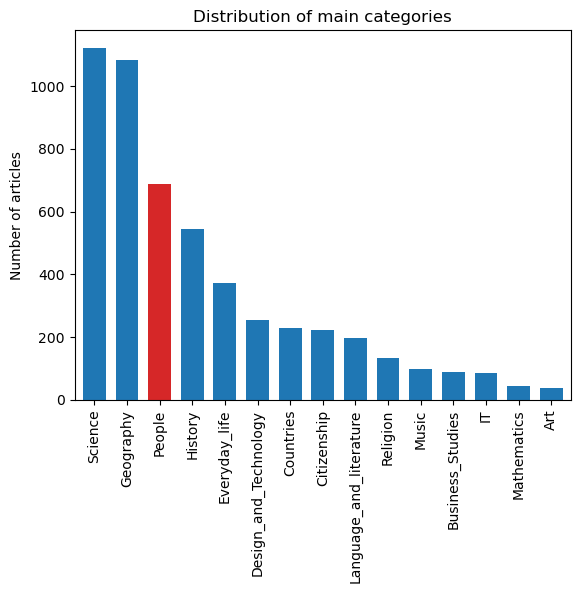

In [59]:
# plotting the distribution of main_categories
maincategories_dist = main_categories["main_category"].value_counts()
colors = ['tab:red' if (x == "People") else 'tab:blue' for x in maincategories_dist.keys()]
maincategories_dist.plot.bar(title = "Distribution of main categories",
                             ylabel = 'Number of articles', 
                             color = colors,
                             width = 0.7)
plt.show()

We will now take a closer look of the articles and their subcategories within the People category.

In [60]:
# finding the articles that are in the People category
categories["category_people"] = categories["category"].apply(lambda x: x.startswith('subject.People.'))

# constructing a new dataframe called people, only with articles from the people category
people = categories[categories["category_people"] == True]

# splitting the categories into main- and subcategories
people = pd.concat([people, people['category'].str.split(".", expand=True)], axis=1)
people = people.drop(columns = ["category_people", "category", 0, 1])
people = people.rename(columns = {"article":"name", 2:"category"})

The number of articles about people are 689


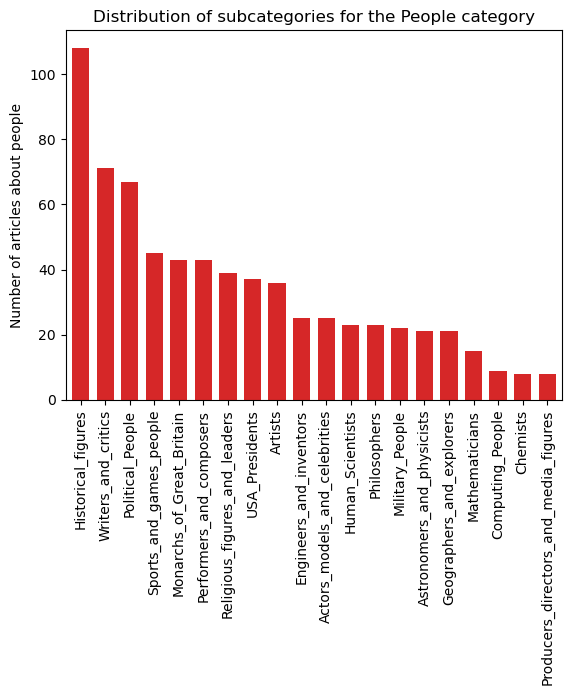

In [61]:
print(f"The number of articles about people are {len(people)}")

# plotting the distribution of subcategories within the People category
subcategories_dist = people["category"].value_counts()
subcategories_dist.plot.bar(title = "Distribution of subcategories for the People category",
                            ylabel = 'Number of articles about people', 
                            color = "tab:red", width = 0.7)
plt.show()

For our project goals, we need to be able to identify between women and men articles. In the following cells, we will do so by using the `female` dataframe, as well as finding every node degree, i.e., every number of incoming and outcoming links from every article.

In [62]:
# identify women and men in people
people["gender"] =  people['name'].isin(female["name"])
people["gender"] = people["gender"].apply(lambda x: "female" if x else "male")

# counting in- and out-links for every article
count_links_src = links.link_source.value_counts()
count_links_target = links.link_target.value_counts()

# drop all people that have no in_link -> impossible to reach the article
people = people.merge(count_links_src, how = "left", left_on = "name", right_index = True)
people = people.merge(count_links_target, how = "inner", left_on = "name", right_index = True)
people = people.rename(columns = {"link_source": "nr_link_out", "link_target": "nr_link_in"})
people.head()

,name,category,gender,nr_link_in,nr_link_out
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Historical_figures,male,NaN,11
4,%C3%89douard_Manet,Artists,male,NaN,20
8,%C3%93engus_I_of_the_Picts,Historical_figures,male,NaN,10
67,A._E._J._Collins,Sports_and_games_people,male,NaN,9
88,Abbas_I_of_Persia,Historical_figures,male,NaN,14


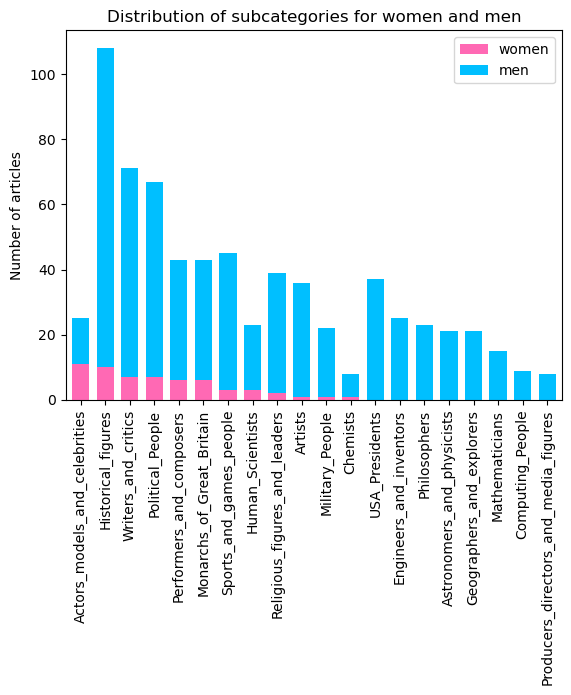

In [65]:
women_people = people[people['gender'] == "female"]["category"].value_counts()
men_people = people[people['gender'] == "male"]["category"].value_counts()
index = men_people.keys()
men_women_cat = pd.DataFrame({'women': women_people,'men': men_people}, index=index).sort_values(by = ["women"], ascending = False)
ax = men_women_cat.plot.bar(stacked = True, color = ['hotpink', 'deepskyblue'], 
                            title = "Distribution of subcategories for women and men",
                            ylabel = 'Number of articles', width = 0.7)

plt.show()

Now, we will construct a new dataframe called `path_overview` that contains the following columns:

| **Column_name**      | **Description**                                                     |
|----------------------|---------------------------------------------------------------------|
| source               | Source article of navigated path                                    |
| target               | Target article of navigated path                                    |
| finished             | True if path was finished, false otherwise                          |
| human_path_length    | The length of the path it took the user to go from source to target |
| shortest_path_length | Shortest possible path from a source to a target                    |
| durationInSec        | Duration of game                                                    |
| type                 | Reason for unfinished game                                          |
| failure_article      | Title of article where game was failed (unfinished)                 |

In [10]:
def process_path(path):
    '''
    Decompose a path and find its length. 
    Assumption: When back-clicks are encountered, we increase the path length by 1.
    :param path: a full-length path
    :return: source, target, length
    '''
    p = path.split(";")
    source = p[0]
    target = p[-1]
    length = len(p)
    return source, target, length

In [11]:
# expand the finished paths 
path_fin = paths_finished.copy()
path_fin["source"], path_fin["target"], path_fin["human_path_length"] =  zip(*paths_finished['path'].apply(lambda x: process_path(x)))
path_fin["finished"] = True

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin["source"], path_ufin["failure_article"], path_ufin["human_path_length"] = zip(*paths_unfinished['path'].apply(lambda x: process_path(x)))
path_ufin["finished"] = False
path_ufin['target'] = paths_unfinished["target"]

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin])
path_overview = path_overview[["source", "target", "finished", "human_path_length", 
                               "durationInSec", "type", "failure_article"]]

**Finding the shortest path length and adding it to `path_overview`:**

In [12]:
# The Shortest Distance Matrix is created from the imported data
shortest_distance_matrix = [] # TODO: Might want to have them as numpy arrays from the beginning
for row in shortest_distance_text:
    row_formated = [] 
    for c in row:
        if c.isdigit(): #TODO: Might want to do with safe casting instead
            row_formated.append(int(c))
        else:
            row_formated.append(-1) ## If there is no path between two articles it's represented with -1
        
    shortest_distance_matrix.append(np.array(row_formated))

shortest_distance_matrix = np.array(shortest_distance_matrix)

#How to access multiple values in the matrix at once shortest_distance_matrix[(row1,row2,row3),(col1,col2,col3)]

In [13]:
# Paths with target articles that don't exist are deleted
condition = ~(path_overview['target'].isin(articles['article'].array))
path_overview = path_overview.drop(path_overview[condition].index)

In [14]:
# shortest path length is added to the path_overview

def get_articles_indexes(article_names):
    indexes = []
    for article in article_names.array:
        indexes.append(articles.index[articles['article'] == article].tolist()[0])
    return tuple(indexes)

path_overview['shortest_path_length'] = shortest_distance_matrix[get_articles_indexes(path_overview['source']), 
                                                                 get_articles_indexes(path_overview['target'])]

In [15]:
# Infeasible source -> target paths are removed, where the shortest path is -1
path_overview = path_overview.drop(path_overview[path_overview['shortest_path_length'] < 0].index) 
path_overview.insert(4, 'shortest_path_length', path_overview.pop('shortest_path_length'))
path_overview

,source,target,finished,human_path_length,shortest_path_length,durationInSec,type,failure_article
0,14th_century,African_slave_trade,True,9,3,166,NaN,NaN
1,14th_century,African_slave_trade,True,5,3,88,NaN,NaN
2,14th_century,African_slave_trade,True,8,3,138,NaN,NaN
3,14th_century,Greece,True,4,2,37,NaN,NaN
4,14th_century,John_F._Kennedy,True,7,3,175,NaN,NaN
...,...,...,...,...,...,...,...,...
24870,Franz_Kafka,Cholera,False,8,3,180,restart,Ghana
24871,Modern_history,Hollandic,False,1,3,6,restart,Modern_history
24872,Computer_programming,The_Beatles,False,5,3,1900,timeout,<
24873,Jamaica,Alan_Turing,False,4,3,1903,timeout,Battle_of_Midway


In [16]:
# save dataframe to file
path_overview.to_csv("./data/all_paths_overview.csv")

Let's turn our attention to all people, and identify the paths in `path_overview` that only have people as target article:

In [17]:
# find only targets that are people
people_target_paths = path_overview.merge(people[['name', 'category', 'gender']], 
                                          how = "inner", left_on = "target", right_on = "name")

We can then find all paths that have targets that are women:

In [18]:
# find only targets that are women
women_target_paths = people_target_paths[people_target_paths['gender'] == "female"]
print(f"The number of paths that have women as a target article is {len(women_target_paths)}")

The number of paths that have women as a target article is 689


**A closer look of men vs. women articles**

In [26]:
women = len(people_target_paths[people_target_paths['gender'] == "female"])
men = len(people_target_paths[people_target_paths['gender'] == "male"])
women_finished = len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == True)])
men_finished = len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == True)])
women_unfinished = len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == False)])
men_unfinished = len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == False)])

print("Number of paths with a woman as a target", women)
print("Number of paths with a man as a target", men)
print()
print("Number of finished paths with a woman as a target", women_finished)
print("Number of finished paths with a man as a target", men_finished)
print()
print("Number of unfinished paths with a woman as a target", women_unfinished)
print("Number of unfinished paths with a man as a target", men_unfinished)

Number of paths with a woman as a target 689
Number of paths with a man as a target 8133

Number of finished paths with a woman as a target 347
Number of finished paths with a man as a target 5721

Number of unfinished paths with a woman as a target 342
Number of unfinished paths with a man as a target 2412


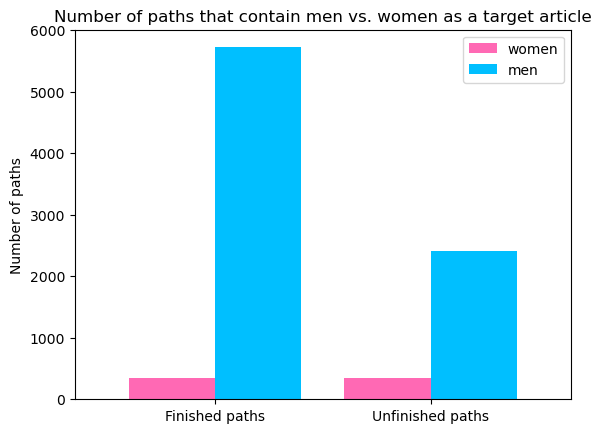

In [27]:
women = [women_finished, women_unfinished]
men = [men_finished, men_unfinished]
index = ['Finished paths', 'Unfinished paths']
compare_mv = pd.DataFrame({'women': women,'men': men}, index=index)
ax = compare_mv.plot.bar(rot=0, color = ['hotpink','deepskyblue'], 
                         title = "Number of paths that contain men vs. women as a target article",
                         ylabel = 'Number of paths', width = 0.8)

To compute the success rate of finishing a path with a certain target article, we will count how many times a game with a certain target article was finished, and divide it with the total number of paths where it was the target:

In [19]:
# count total, finished and unfinished number of times a target article was reached
tot_target = people_target_paths.target.value_counts().rename("tot_target_count")
fin_target = people_target_paths[people_target_paths['finished'] == True].target.value_counts().rename("fin_target_count")
unf_target = people_target_paths[people_target_paths['finished'] == False].target.value_counts().rename("unf_target_count")

# add this information to the people dataframe
people = people.merge(tot_target, how = "left",  left_on = "name", right_index = True)
people = people.merge(unf_target, how = "left",  left_on = "name", right_index = True)
people = people.merge(fin_target, how = "left",  left_on = "name", right_index = True)

In [20]:
# compute success rate of finishing a path
people['succ_rate'] = people['fin_target_count']/people['tot_target_count']

In [21]:
people.to_csv("./data/people_overview.csv")

### **Controlling for all confounding factors** - NOT FINISHED

Example: If five different paths exist from the source article *14th_century* towards the target article *Elizabeth_I_of_England*, and two different paths exist from the same source article towards the target article *John_F._Kennedy*, we would get $5 \times 2 = 10$ number of pairs to compare.

In [89]:
df = path_overview.merge(people, how = "inner", left_on = 'target', right_on = 'name')
df.drop(['name'], axis=1)

,source,target,finished,human_path_length,shortest_path_length,durationInSec,type,failure_article,category,gender,nr_link_in,nr_link_out
0,14th_century,John_F._Kennedy,True,7,3,175,NaN,NaN,USA_Presidents,male,60.0,68
1,14th_century,John_F._Kennedy,True,6,3,110,NaN,NaN,USA_Presidents,male,60.0,68
2,Diamond,John_F._Kennedy,True,5,2,160,NaN,NaN,USA_Presidents,male,60.0,68
3,Genetics,John_F._Kennedy,True,5,3,74,NaN,NaN,USA_Presidents,male,60.0,68
4,Genetics,John_F._Kennedy,True,5,3,125,NaN,NaN,USA_Presidents,male,60.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...
8817,Alternating_current,Anton%C3%ADn_Dvo%C5%99%C3%A1k,False,12,3,154,restart,Musical_instrument,Performers_and_composers,male,7.0,21
8818,Aardvark,Henry_Moore,False,5,3,127,restart,University_of_Cambridge,Artists,male,5.0,21
8819,Sundew,Colley_Cibber,False,1,4,1825,timeout,Sundew,Writers_and_critics,male,7.0,14
8820,Soddo_language,Georg_Cantor,False,3,3,319,restart,Charles_Dickens,Mathematicians,male,12.0,22


In [90]:
prufa = df.merge(df, on = ["source", "shortest_path_length"], how = "inner")

In [91]:
prufa

,source,target_x,finished_x,human_path_length_x,shortest_path_length,durationInSec_x,type_x,failure_article_x,name_x,category_x,...,finished_y,human_path_length_y,durationInSec_y,type_y,failure_article_y,name_y,category_y,gender_y,nr_link_in_y,nr_link_out_y
0,14th_century,John_F._Kennedy,True,7,3,175,NaN,NaN,John_F._Kennedy,USA_Presidents,...,True,7,175,NaN,NaN,John_F._Kennedy,USA_Presidents,male,60.0,68
1,14th_century,John_F._Kennedy,True,7,3,175,NaN,NaN,John_F._Kennedy,USA_Presidents,...,True,6,110,NaN,NaN,John_F._Kennedy,USA_Presidents,male,60.0,68
2,14th_century,John_F._Kennedy,True,7,3,175,NaN,NaN,John_F._Kennedy,USA_Presidents,...,True,27,507,NaN,NaN,Henry_David_Thoreau,Philosophers,male,10.0,22
3,14th_century,John_F._Kennedy,True,7,3,175,NaN,NaN,John_F._Kennedy,USA_Presidents,...,False,4,1902,timeout,United_States,Henry_David_Thoreau,Philosophers,male,10.0,22
4,14th_century,John_F._Kennedy,True,7,3,175,NaN,NaN,John_F._Kennedy,USA_Presidents,...,False,2,44,restart,Europe,Hannibal_Barca,Historical_figures,male,4.0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73099,Flag_of_the_Republic_of_China,Henry_James,False,10,3,163,restart,<,Henry_James,Writers_and_critics,...,False,10,163,restart,<,Henry_James,Writers_and_critics,male,14.0,41
73100,Amtrak,Anton%C3%ADn_Dvo%C5%99%C3%A1k,False,1,3,1805,timeout,Amtrak,Anton%C3%ADn_Dvo%C5%99%C3%A1k,Performers_and_composers,...,False,1,1805,timeout,Amtrak,Anton%C3%ADn_Dvo%C5%99%C3%A1k,Performers_and_composers,male,7.0,21
73101,Alternating_current,Anton%C3%ADn_Dvo%C5%99%C3%A1k,False,12,3,154,restart,Musical_instrument,Anton%C3%ADn_Dvo%C5%99%C3%A1k,Performers_and_composers,...,False,12,154,restart,Musical_instrument,Anton%C3%ADn_Dvo%C5%99%C3%A1k,Performers_and_composers,male,7.0,21
73102,Sundew,Colley_Cibber,False,1,4,1825,timeout,Sundew,Colley_Cibber,Writers_and_critics,...,False,1,1825,timeout,Sundew,Colley_Cibber,Writers_and_critics,male,7.0,14


In [154]:
comb_finpaths = finpaths_women_target[["source", "path", "target"]].merge(finpaths_men_target[["source", "path", "target"]], 
                                                        on=['source'], how = "inner",
                                                        suffixes=('_women', '_men'))

In [155]:
comb_finpaths

,source,path_women,target_women,path_men,target_men
0,14th_century,14th_century;England;London;Spanish_Armada;Eng...,Elizabeth_I_of_England,14th_century;Italy;Roman_Catholic_Church;HIV;R...,John_F._Kennedy
1,14th_century,14th_century;England;London;Spanish_Armada;Eng...,Elizabeth_I_of_England,14th_century;Europe;North_America;United_State...,John_F._Kennedy
2,14th_century,14th_century;England;London;Spanish_Armada;Eng...,Elizabeth_I_of_England,14th_century;Europe;<;England;<;Christianity;A...,Henry_David_Thoreau
3,14th_century,14th_century;England;James_I_of_England;Elizab...,Elizabeth_I_of_England,14th_century;Italy;Roman_Catholic_Church;HIV;R...,John_F._Kennedy
4,14th_century,14th_century;England;James_I_of_England;Elizab...,Elizabeth_I_of_England,14th_century;Europe;North_America;United_State...,John_F._Kennedy
...,...,...,...,...,...
469,Ununoctium,Ununoctium;Uranium;World_War_II;The_Holocaust;...,Anne_Frank,Ununoctium;Russia;United_Kingdom;British_monar...,Henry_IV_of_England
470,William_Pitt_the_Younger,William_Pitt_the_Younger;Prime_Minister_of_the...,Miranda_Otto,William_Pitt_the_Younger;British_Empire;Ottoma...,Socrates
471,Windows_2000,Windows_2000;North_America;California;Arnold_S...,Bette_Davis,Windows_2000;Microsoft;United_States;George_Wa...,Ronald_Reagan
472,Windows_2000,Windows_2000;North_America;United_States;Cinem...,Bette_Davis,Windows_2000;Microsoft;United_States;George_Wa...,Ronald_Reagan
